In [1]:
# Streaming LSTM Autoencoder (Paper-Aligned, SAND-Inspired, Optimized)

import os, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from collections import deque

from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Configuration
DATA_DIR = "generated_datasets"
RESULTS_DIR = "results_streaming"
os.makedirs(RESULTS_DIR, exist_ok=True)

WINDOW_SIZE = 30
LATENT_DIM = 32
BATCH_SIZE = 32
EPOCHS = 3
CONTAMINATION = 0.05
INITIAL_TRAIN_SIZE = 2000
RETRAIN_INTERVAL = 5000

In [2]:
# Build LSTM Autoencoder
def build_model(window_size):
    input_layer = Input(shape=(window_size, 1))
    encoded = LSTM(LATENT_DIM, activation='relu')(input_layer)
    decoded = RepeatVector(window_size)(encoded)
    decoded = LSTM(LATENT_DIM, activation='relu', return_sequences=True)(decoded)
    output = TimeDistributed(Dense(1))(decoded)
    return Model(inputs=input_layer, outputs=output)

# Create overlapping sequences
def create_sequences(data, window_size):
    return np.array([data[i:i + window_size] for i in range(len(data) - window_size)])

# Run streaming LSTM with batch prediction and periodic retraining
def run_streaming_lstm(ts_scaled):
    start_time = time.time()

    buffer = deque(ts_scaled[:INITIAL_TRAIN_SIZE], maxlen=INITIAL_TRAIN_SIZE)
    scores = []

    # Initial training
    model = build_model(WINDOW_SIZE)
    model.compile(optimizer='adam', loss='mse')
    initial_train = create_sequences(np.array(buffer), WINDOW_SIZE).reshape((-1, WINDOW_SIZE, 1))
    model.fit(initial_train, initial_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

    # Create prediction windows
    all_windows = create_sequences(ts_scaled, WINDOW_SIZE).reshape((-1, WINDOW_SIZE, 1))
    preds = model.predict(all_windows, verbose=0)
    errors = np.mean((all_windows - preds) ** 2, axis=(1, 2))
    scores = [0.0] * WINDOW_SIZE + list(errors)

    # Retraining periodically
    for i in range(INITIAL_TRAIN_SIZE, len(ts_scaled), RETRAIN_INTERVAL):
        if i + RETRAIN_INTERVAL >= len(ts_scaled):
            break
        buffer.extend(ts_scaled[i:i + RETRAIN_INTERVAL])
        retrain_seq = create_sequences(np.array(buffer), WINDOW_SIZE).reshape((-1, WINDOW_SIZE, 1))
        model.fit(retrain_seq, retrain_seq, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

    elapsed = time.time() - start_time
    return np.array(scores[:len(ts_scaled)]), elapsed


Processing normality_1_daphnet.npy
Precision: 0.044, Recall: 0.020, F1: 0.028, AUC: 0.233, Time: 39.39s


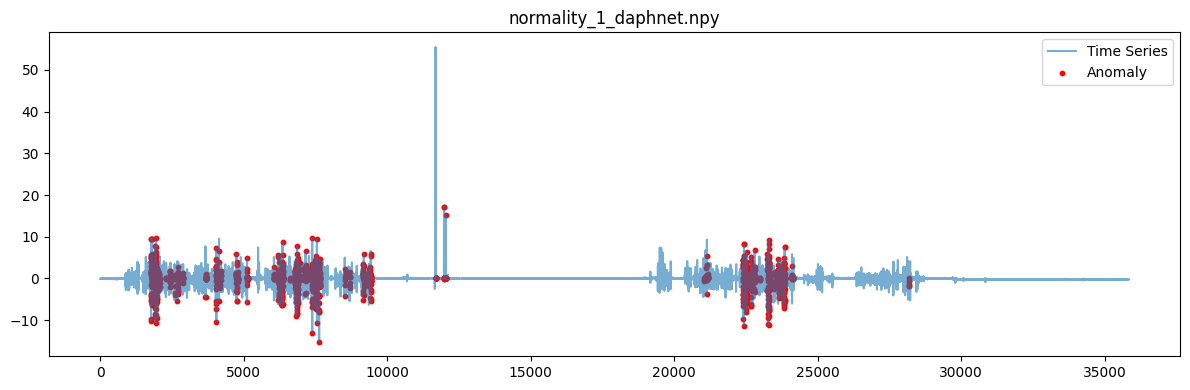


Processing normality_1_genesis.npy
Precision: 0.043, Recall: 0.680, F1: 0.080, AUC: 0.893, Time: 21.81s


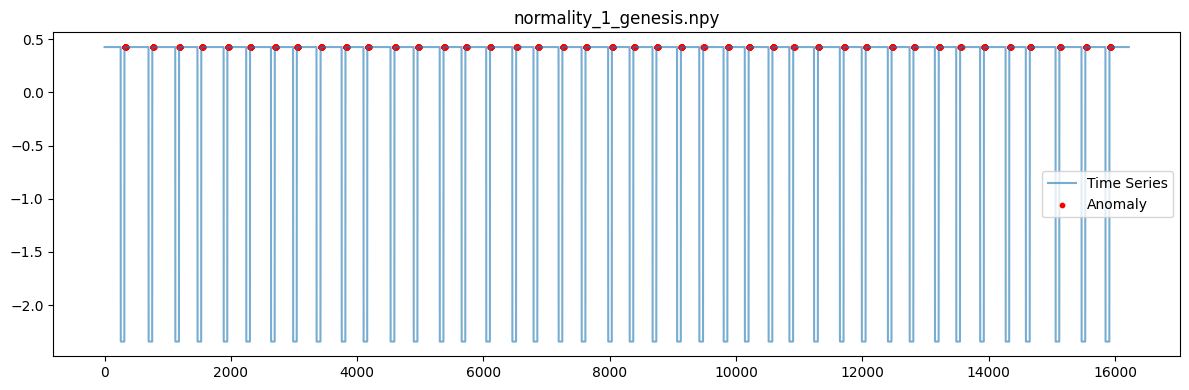


Processing normality_1_nasa-msl.npy
Precision: 0.141, Recall: 0.112, F1: 0.124, AUC: 0.638, Time: 10.92s


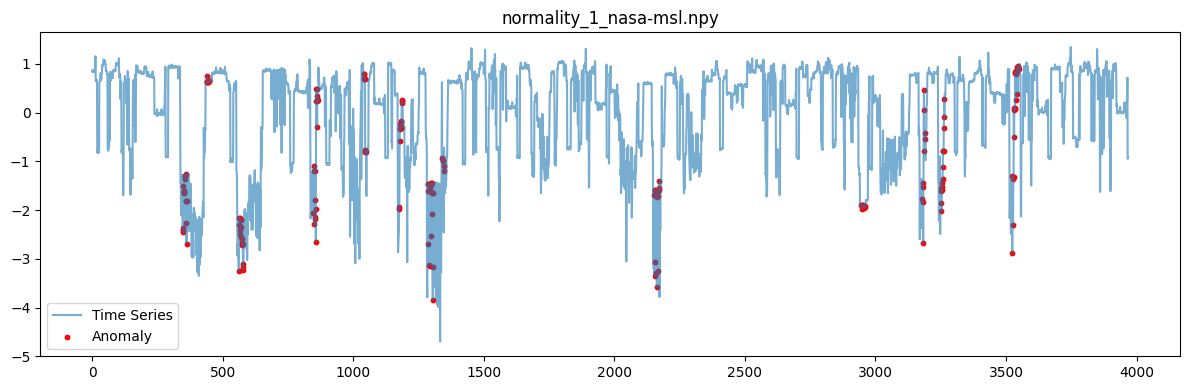


Processing normality_2_1_daphnet_genesis.npy
Precision: 0.048, Recall: 0.028, F1: 0.035, AUC: 0.522, Time: 30.98s


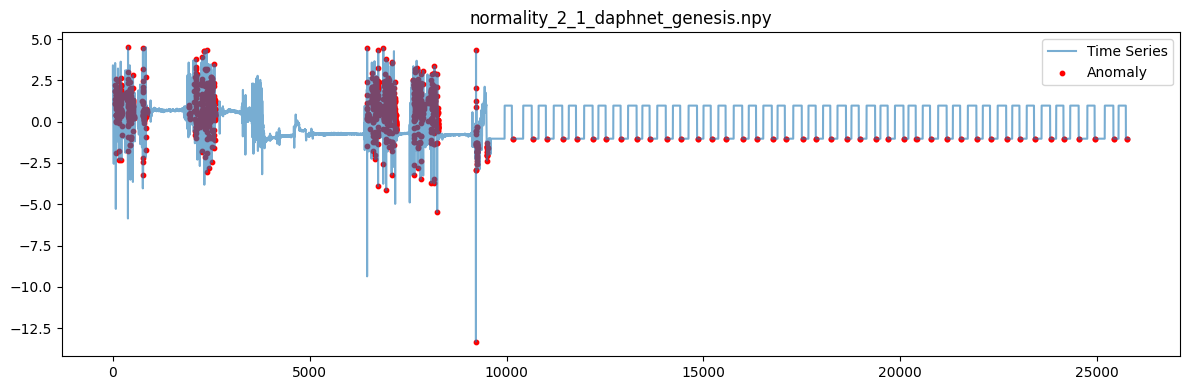


Processing normality_2_2_daphnet_nasa-msl.npy
Precision: 0.201, Recall: 0.040, F1: 0.067, AUC: 0.372, Time: 47.14s


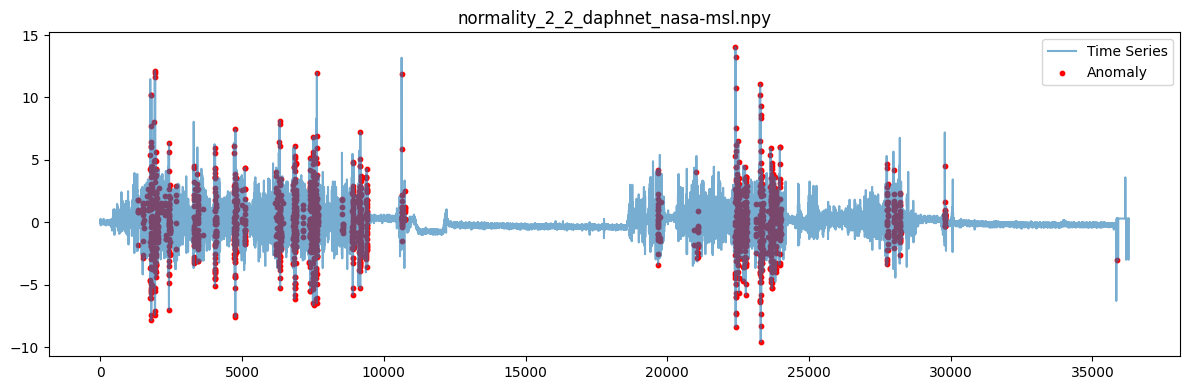


Processing normality_2_3_genesis_nasa-msl.npy
Precision: 0.064, Recall: 0.085, F1: 0.073, AUC: 0.639, Time: 34.95s


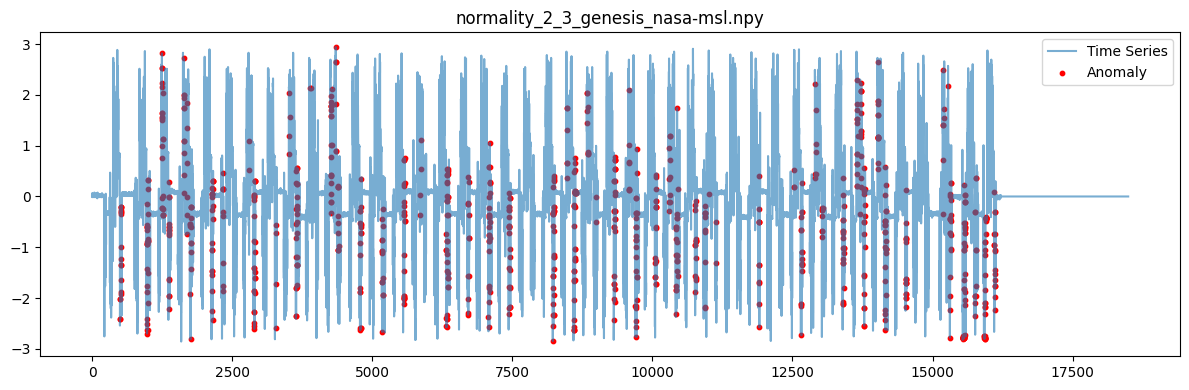


Processing normality_3_1_daphnet_genesis_nasa-msl.npy
Precision: 0.098, Recall: 0.064, F1: 0.078, AUC: 0.688, Time: 74.21s


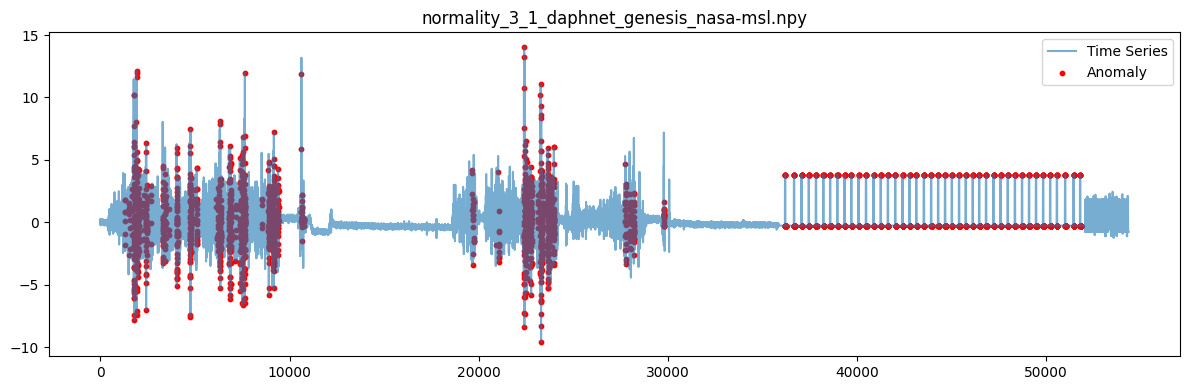


Processing normality_3_2_genesis_nasa-msl_daphnet.npy
Precision: 0.135, Recall: 0.051, F1: 0.075, AUC: 0.437, Time: 67.12s


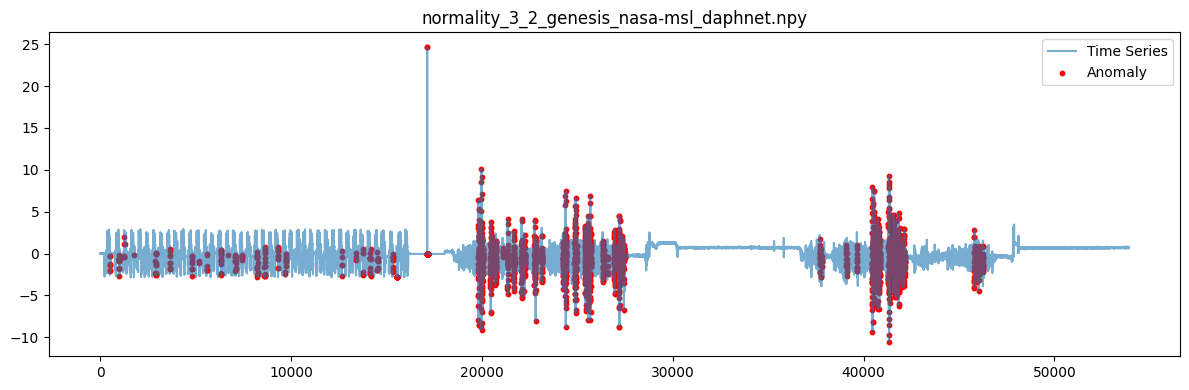


Processing normality_3_3_nasa-msl_daphnet_genesis.npy
Precision: 0.025, Recall: 0.008, F1: 0.013, AUC: 0.456, Time: 50.24s


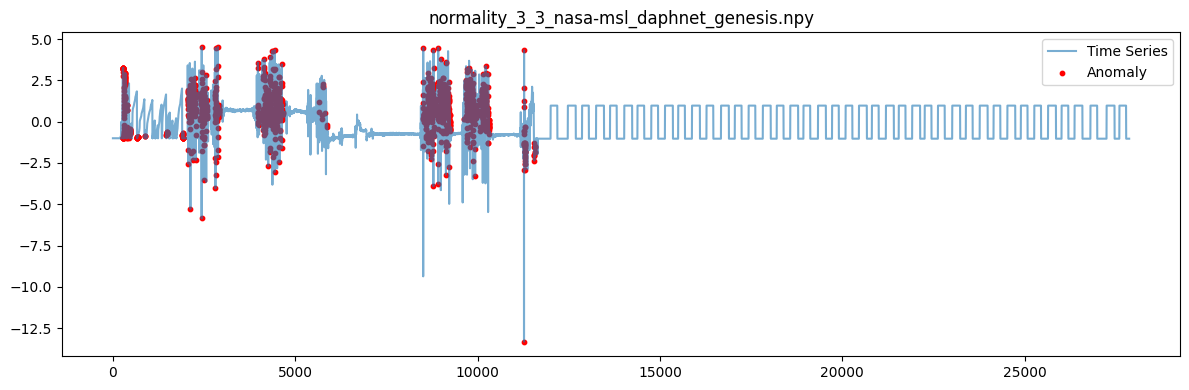

In [3]:
# Run full evaluation
summary = []

for fname in sorted(os.listdir(DATA_DIR)):
    if not fname.endswith(".npy") or "_labels" in fname or "_boundaries" in fname:
        continue

    print(f"\nProcessing {fname}")
    ts_path = os.path.join(DATA_DIR, fname)
    label_path = ts_path.replace(".npy", "_labels.npy")

    if not os.path.exists(label_path):
        print(f"Skipping {fname}, missing labels.")
        continue

    raw_ts = np.load(ts_path)
    labels = np.load(label_path)

    if len(raw_ts) < INITIAL_TRAIN_SIZE + WINDOW_SIZE:
        print("Skipped: Too short for streaming processing")
        continue

    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(raw_ts.reshape(-1, 1)).flatten()

    scores, runtime = run_streaming_lstm(ts_scaled)
    threshold = np.percentile(scores, 100 * (1 - CONTAMINATION))
    preds = (scores > threshold).astype(int)

    y_true = labels[:len(preds)]

    # Evaluation
    p = precision_score(y_true, preds, zero_division=0)
    r = recall_score(y_true, preds, zero_division=0)
    f = f1_score(y_true, preds, zero_division=0)
    a = roc_auc_score(y_true, scores) if len(set(y_true)) > 1 else 0.0

    print(f"Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, AUC: {a:.3f}, Time: {runtime:.2f}s")

    # Visualization
    plt.figure(figsize=(12, 4))
    plt.plot(raw_ts, label="Time Series", alpha=0.6)
    anomaly_idx = np.where(preds == 1)[0]
    plt.scatter(anomaly_idx, raw_ts[anomaly_idx], color='red', s=10, label="Anomaly")
    plt.title(fname)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, fname.replace(".npy", ".png")))
    plt.show()
    plt.close()

    summary.append(dict(dataset=fname, length=len(raw_ts),
                        precision=round(p, 3), recall=round(r, 3),
                        f1=round(f, 3), auc=round(a, 3), time=round(runtime, 2)))


In [4]:
if summary:
    df = pd.DataFrame(summary).set_index("dataset")
    display(df)
    df.to_csv(os.path.join(RESULTS_DIR, "streaming_lstm_v2_results.csv"))
else:
    print("No datasets were successfully processed.")

,length,precision,recall,f1,auc,time
dataset,,,,,,
normality_1_daphnet.npy,35840,0.044,0.020,0.028,0.233,39.39
normality_1_genesis.npy,16220,0.043,0.680,0.080,0.893,21.81
normality_1_nasa-msl.npy,3969,0.141,0.112,0.124,0.638,10.92
normality_2_1_daphnet_genesis.npy,25820,0.048,0.028,0.035,0.522,30.98
normality_2_2_daphnet_nasa-msl.npy,36279,0.201,0.040,0.067,0.372,47.14
normality_2_3_genesis_nasa-msl.npy,18492,0.064,0.085,0.073,0.639,34.95
normality_3_1_daphnet_genesis_nasa-msl.npy,54363,0.098,0.064,0.078,0.688,74.21
normality_3_2_genesis_nasa-msl_daphnet.npy,53887,0.135,0.051,0.075,0.437,67.12
normality_3_3_nasa-msl_daphnet_genesis.npy,27871,0.025,0.008,0.013,0.456,50.24
